In [24]:
import keras
from keras.models import load_model
from keras.preprocessing import image

from tensorflow.keras.utils import load_img, img_to_array
import tensorflow as tf
import seaborn as sns
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# from PIL import Image
import PIL
print(tf.config.list_physical_devices('GPU'))

import SciServer.CasJobs as CasJobs # query with CasJobs, the primary database for the SDSS
import SciServer.SkyServer as SkyServer # show individual objects through SkyServer
import SciServer.SciDrive

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# # Helper functions for visualization:
def plot_confusion_matrix(y_true, y_pred,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    From scikit-learn: plots a confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    #fixes "squishing of plot"
    plt.ylim([1.5, -.5])

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

In [36]:
# Load the trained model
# model = models.load_model(f'../Models/{modelStr}.h5')
# modelName = f'pcc_resnet50_{modelNum}' # template is currently pcc_resnet50_X, where X is the iteration of the model

modelName = f'cluster_pcc_resnet50_7' # template is currently pcc_resnet50_X, where X is the iteration of the model
model = keras.models.load_model(f'../Models/{modelName}.h5')



IMG_WIDTH, IMG_HEIGHT = 200, 200
def make_prediction(img_path):
    # Load and preprocess the input image
    # img_path = '../Images/PCC-and-SpecSearch/sdss_ra=48.9999795273873_dec=41.2875102706543-label=0.png'
    img = image.load_img(img_path, target_size=(IMG_WIDTH, IMG_HEIGHT))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.  # Normalize pixel values (assuming your model was trained with normalized inputs)
    
    # Make predictions
    predictions = model.predict(img_array)
    
    # Postprocess predictions
    predicted_class = np.argmax(predictions)  # Assuming your model outputs class probabilities
    class_labels = ['0', '1']  # Define your class labels accordingly
    predicted_label = class_labels[predicted_class]
    
    # print('Predicted class:', predicted_label)
    return(predicted_label)

trainImgs = os.path.join('..', 'Images', 'PCC-and-SpecSearch', '*.png')

counter = 0
for ind, x in enumerate(glob.glob(trainImgs)):
    if make_prediction(x) != x[-5]:
        counter += 1

print(f'{counter} misses on training set')
print(f'{len(glob.glob(trainImgs))} images in training set')


25 misses on training set
479 images in training set


In [85]:
train_crossMatch = pd.read_csv('../Sheets/trainObjectsCrossMatched.csv', skiprows = 1)
train_crossMatch

,labels,objID,ra,dec,r,u_g,g_z,g_r
0,0,1237661055281660877,49.602752,41.536737,18.24393,3.259443,2.572918,1.452351
1,0,1237661122387969309,49.800703,41.465476,19.33727,3.921835,2.882999,1.652855
2,0,1237661055281596077,49.389257,41.572095,19.44360,0.974409,0.873505,0.423130
3,0,1237661083199144825,49.359348,41.335516,17.55119,1.983553,1.814596,0.970749
4,0,1237661055281726833,49.539147,41.457701,18.19508,2.887321,2.508780,1.514282
...,...,...,...,...,...,...,...,...
461,1,1237661055282118662,50.622746,41.050445,14.81082,1.767377,1.895410,1.003204
462,1,1237661056355598960,50.694593,41.941230,16.10706,2.217302,1.538662,0.801304
463,1,1237670457511182781,49.705849,40.827589,14.90032,1.862329,1.622120,0.858029
464,1,1237670458048118944,49.112658,41.180216,15.15598,1.778517,1.545025,0.819269


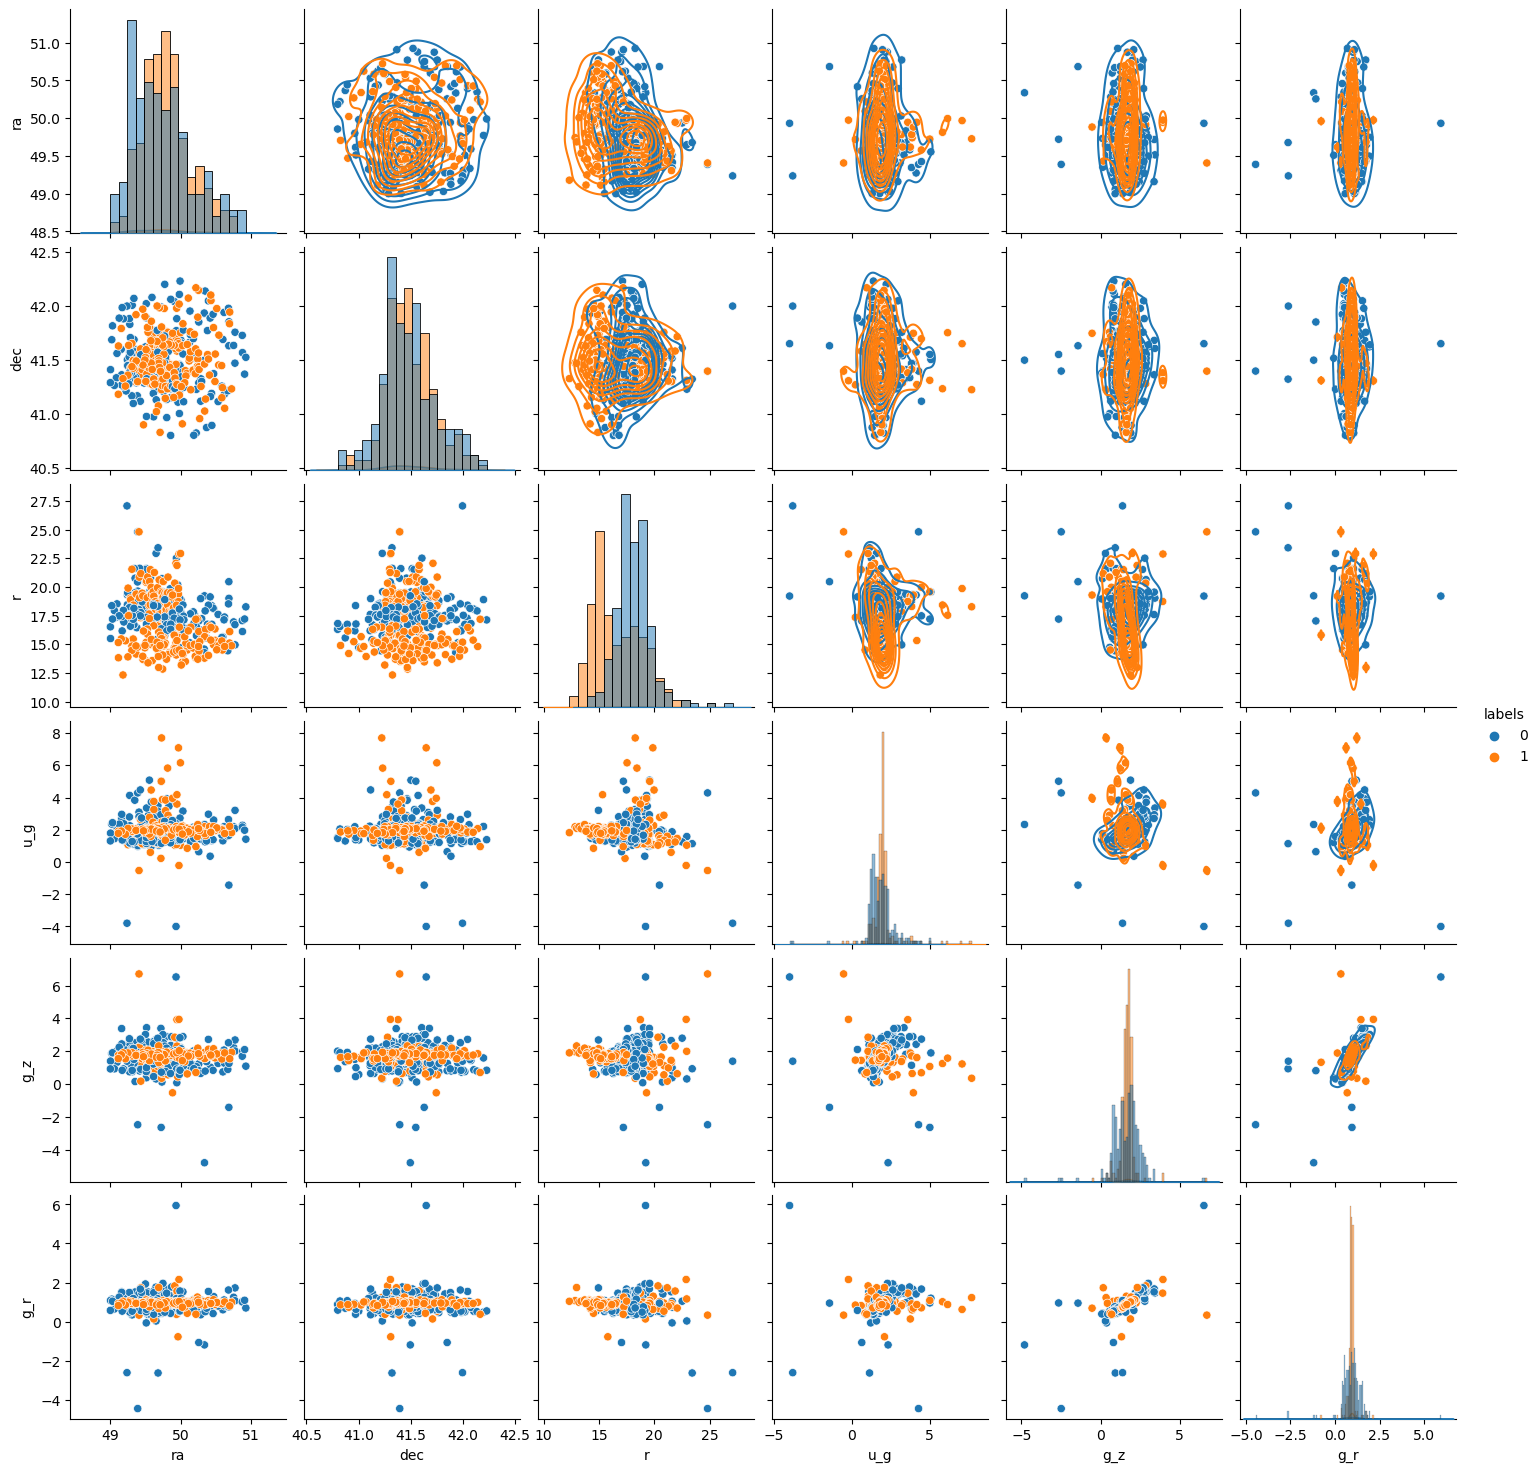

In [4]:
## Uncomment for big pairplot:
pairDf = train_crossMatch[['ra', 'dec', 'r', 'u_g', 'g_z', 'g_r', 'labels']]

p1 = sns.pairplot(pairDf, corner = False, hue = 'labels')
p1.map_diag(sns.histplot)
p1.map_upper(sns.kdeplot)
p1.savefig(f'../Images/{modelName}-classifying-training-set.png')

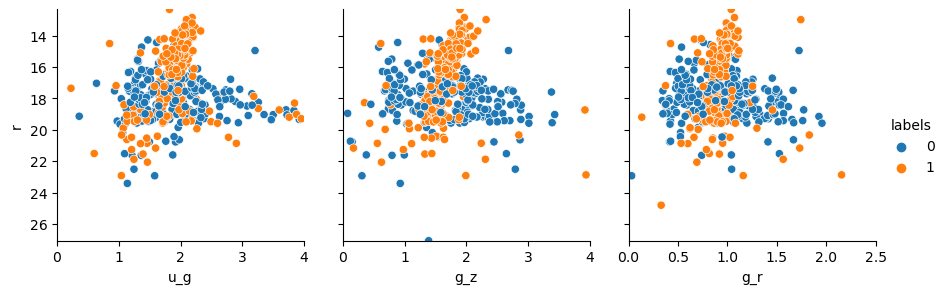

In [5]:
x_vars = pairDf[['u_g', 'g_z', 'g_r']]
y_vars = pairDf[['r']]
y_lim = (y_vars.min()[0], y_vars.max()[0])

f = sns.PairGrid(pairDf, hue="labels", x_vars=x_vars, y_vars=y_vars, height = 3)
# f.map_diag(sns.histplot, color=".3")
f.map_offdiag(sns.scatterplot)
f.add_legend()

## y limits
f.axes[0, 0].set_ylim(y_lim[::-1])

# x limits
f.axes[0, 0].set_xlim((0, 4))
f.axes[0, 1].set_xlim((0, 4))
f.axes[0, 2].set_xlim((0, 2.5))
# f.axes[0, 1].set_xlim(modMagr_lim[::-1])
# f.axes[0, 2].set_xlim(petroRad_r_lim)
f.savefig(f'../Images/{modelName}-Rmag-vs-color.png')


In [6]:
def dra_dec(ra,dec,ra0,dec0) :
	''' calculate angular separation in RA and Dec,
    	given input coords and reference coords,
    	all in radians
	'''
	dra = (np.sin(ra - ra0) * np.cos(dec))
	ddec = -np.cos(ra - ra0) * np.cos(dec) * np.sin(dec0) + np.sin(dec) * np.cos(dec0)
	return np.array([dra, ddec]) # in radians

ra0, dec0 = 49.9506671, 41.5116961 # NGC 1275, from NED

clustCent_R = []
for ra, dec in zip(pairDf['ra'], pairDf['dec']):
    dra, ddec = dra_dec(np.radians(ra), np.radians(dec), np.radians(ra0), np.radians(dec0))
    R_clust = np.sqrt(dra**2+ddec**2) * 75e3
    clustCent_R.append(R_clust)
pairDf['ClusterCentRad'] = clustCent_R

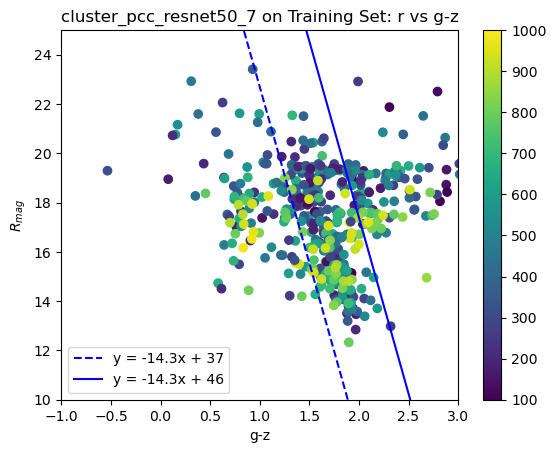

In [7]:
gz_slope = -14.3
gz_intercept1 = 37
gz_intercept2 = 46 # is this one intense enough?

x1 = pairDf['u_g']
x2 = pairDf['g_z']

x3 = pairDf['r']

## TODO -- Get classes on this plot
plt.figure()
xx = np.linspace(-1, 3) 

plt.scatter(x2, x3, c = pairDf['ClusterCentRad'], vmin = 100, vmax = 1000)
plt.plot(xx, xx*gz_slope + gz_intercept1, 'b--', label = f'y = {str(gz_slope)}x + {str(gz_intercept1)}')
plt.plot(xx, xx*gz_slope + gz_intercept2, 'b-', label = f'y = {str(gz_slope)}x + {str(gz_intercept2)}')
plt.ylim([10, 25])
# # plt.xlim(gz_lim)
plt.xlim((-1, 3))
# plt.axvline(x=1.90, color = 'r')
# plt.axvline(x=1.85, color = 'r', label = 'x = 1.85')
# plt.axvline(x=1.30, color = 'r', label = 'x = 1.30')
# plt.axvline(x=1.575, color = 'r', label = 'x = 1.575')
plt.colorbar()
plt.ylabel('$R_{mag}$')
plt.xlabel('g-z')
plt.title(f'{modelName} on Training Set: r vs g-z')
plt.legend()
plt.show()

In [8]:
blueCloud = pairDf.loc[ (pairDf['r'] > -14.3*pairDf['g_z'] + 46)]
redSequence = pairDf.loc[ (pairDf['r'] > -14.3*pairDf['g_z'] + 37) & (pairDf['r'] < -14.3*pairDf['g_z'] + 46)]
redShoulder = pairDf.loc[ (pairDf['r'] < -14.3*pairDf['g_z'] + 37)]

aug_labels_BlueCloud = ['a' + str(x) for x in blueCloud['labels']]
aug_labels_RedSeq = ['b' + str(x) for x in redSequence['labels']]
aug_labels_RedShould = ['c' + str(x) for x in redShoulder['labels']]

# blueCloud['aug_labels'] = aug_labels_BlueCloud
# redSequence['aug_labels'] = aug_labels_RedSeq
# redShoulder['aug_labels'] = aug_labels_RedShould
pairDf.loc[blueCloud.index, 'aug_labels'] = aug_labels_BlueCloud
pairDf.loc[redSequence.index, 'aug_labels'] = aug_labels_RedSeq
pairDf.loc[redShoulder.index, 'aug_labels'] = aug_labels_RedShould

In [34]:
pairDf['labels'].value_counts()
# blueCloud['labels'].value_counts()

0    239
1    227
Name: labels, dtype: int64

In [20]:
colorRegions = pd.concat([blueCloud, redSequence, redShoulder], keys = ['BlueCloud', 'RedSequence', 'RedShoulder'])
colorRegions

ra        dec         r       u_g       g_z       g_r  \
BlueCloud   0    49.602752  41.536737  18.24393  3.259443  2.572918  1.452351   
            1    49.800703  41.465476  19.33727  3.921835  2.882999  1.652855   
            4    49.539147  41.457701  18.19508  2.887321  2.508780  1.514282   
            5    49.702903  41.735900  19.18205  2.072138  2.274450  1.360561   
            7    49.241064  41.499086  18.44905  2.038170  2.095968  1.203882   
...                    ...        ...       ...       ...       ...       ...   
RedShoulder 371  49.688172  41.488764  14.22095  1.873409  1.302334  0.665757   
            383  50.055279  41.286874  15.66404  1.688580  1.352522  0.741722   
            414  49.779843  41.142634  15.09814  1.350511  1.411182  0.698896   
            451  50.021627  40.906238  14.20008  1.735005  1.424113  0.735618   
            459  50.214334  42.165650  17.18630  0.956013  0.700762  0.373486   

                 labels  ClusterCentRad  
BlueCloud   0         0      342.532075  
            1         0      159.007663  
            4         0      409.682186  
            5         0      380.665975  
            7         0      695.806817  
...                 ...             ...  
RedShoulder 371       1      259.088016  
            383       1      311.701397  
            414       1      511.447854  
            451       1      795.602723  
            459       1      893.787509  

[466 rows x 8 columns]

,0,1
BlueCloud,92,10
RedSequence,67,192
RedShoulder,80,25


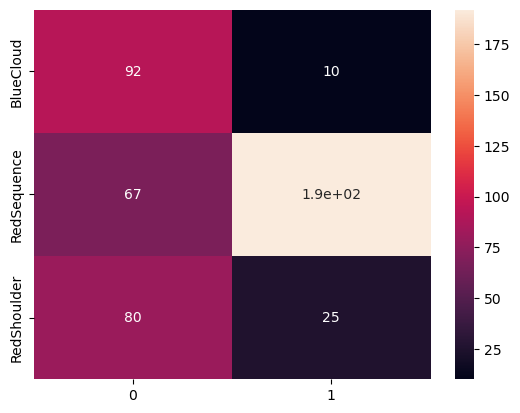

In [63]:
Cols = ['0', '1']
Index = ['BlueCloud', 'RedSequence', 'RedShoulder']


x = np.array([colorRegions['labels']['BlueCloud'].value_counts(),
              colorRegions['labels']['RedSequence'].value_counts()[::-1], # reorder to 0, 1
              colorRegions['labels']['RedShoulder'].value_counts()]
            )

df = pd.DataFrame(x, index=Index, columns=Cols)

sns.heatmap(df, annot=True)
df.style.background_gradient(cmap='Blues')


In [2]:
# colorRegions['labels']['BlueCloud'].value_counts()
# colorRegions['labels']['RedSequence'].value_counts()[::-1]
# colorRegions['labels']['RedShoulder'].value_counts()

In [46]:
def labeler(num):
    if (num > 0.01 and num < 0.033):
        return('1') # members
    else:
        return('0') # background
        

def get_images(df_in, dirName): 
        
    # df_in = df_in.drop_duplicates(subset = 'objID')
    # df_in['labels'] = pd.to_numeric(df_in['labels'], downcast='integer')
    
    img_width, img_height = 200, 200
    SkyServer_DataRelease = 'DR16'
    # dirName = 'PCC-and-SpecSearch'
    
    outDir = os.path.join('..', 'Images', dirName)
    
    fileList = list()

    ## create directory if doesn't currently exist 
    if not os.path.exists(outDir):
       os.makedirs(outDir)

    # if len(glob.glob(os.path.join(outDir, '*.png'))) == df_in.shape[0]:
    #     print('Skipping Populate')
    # else:
        # for id, r, d in zip(searchDf['objID'], df_in['ra'], df_in['dec']):
    
    for r, d, l in zip(df_in['ra'], df_in['dec'], df_in['labels']):
        img_array = SkyServer.getJpegImgCutout(ra = r, 
                                               dec = d, 
                                               width = img_width, 
                                               height = img_height, 
                                               scale = 0.1, 
                                               dataRelease = SkyServer_DataRelease)
        
        # print(f'{id}-label={labeler(z)}')
        # outPicTemplate = f'{id}-label={labeler(z)}.png'
        
        outPicTemplate = f'sdss_ra={r}_dec={d}-label={l}.png'
        
        img0 = PIL.Image.fromarray(img_array, 'RGB')
        img0.save(f'{outDir}/{outPicTemplate}')
        fileList.append(f'{outPicTemplate}')

    # print(f'Finished populate with {len(fileList)} images')

In [47]:
searchDf = pd.read_csv('../Sheets/testSearch_SQL4_9_2024 7_16_13 AM.csv', skiprows = 1)

In [52]:
label_map = map(labeler, searchDf['z'])
searchDf['labels'] = list(label_map)
searchDf['labels'] = searchDf['labels'].astype(str)
searchDf['labels'].value_counts()


0    393
1    259
Name: labels, dtype: int64

In [112]:
searchDf.drop_duplicates(subset = 'objID')
def intersection(lst1, lst2):
    return list(set(lst1) & set(lst2))
common_objs = intersection(searchDf['objID'], train_crossMatch['objID'])
cleanSearch = searchDf[~searchDf.objID.isin(common_objs)] 
cleanSearch.shape[0] == searchDf.shape[0] - len(common_objs)
searchDf.shape[0] - len(common_objs)
cleanSearch

,objID,ra,dec,R_mag,r0,g_z0,u_g,g_z,g_r,g_i,r_i,r_z,petroRad_r,specObjID,z,zErr,zWarning,distance,labels
296,1237661059574661957,50.710846,41.027840,16.33656,15.97445,1.314066,1.888941,1.637344,0.870218,1.332084,0.461865,0.767126,6.796121,1875767986678163456,0.020303,0.000013,0,45.113039,1
297,1237661059574661957,50.710846,41.027840,16.33656,15.97445,1.314066,1.888941,1.637344,0.870218,1.332084,0.461865,0.767126,6.796121,1874640712130127872,0.020311,0.000013,0,45.113039,1
298,1237661083199472526,50.255604,40.797779,13.90260,13.56451,1.520636,2.064993,1.822474,0.983810,1.466329,0.482519,0.838664,15.856580,1875785578864207872,0.020331,0.000006,0,45.130872,1
299,1237661121850901466,48.972134,41.323307,16.07555,15.72467,1.423419,1.829842,1.736673,0.942299,1.395979,0.453680,0.794374,10.782550,1875835331765364736,0.019887,0.000014,0,45.303945,1
300,1237661059574007036,49.106176,41.936792,17.15317,16.78016,1.873536,2.328091,2.206551,1.235912,1.757078,0.521166,0.970638,4.629614,1875858696387454976,0.113469,0.000023,0,45.419668,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
647,1237661061184619260,50.041287,42.962649,14.95002,14.52303,1.138123,1.914467,1.519324,0.902732,1.327225,0.424493,0.616592,20.111860,1874746540124301312,0.018849,0.000013,0,87.074371,1
648,1237661061184685028,50.183969,42.967872,16.34030,15.92945,1.543229,2.023552,1.910030,1.027729,1.522601,0.494872,0.882301,4.108245,1875905975387449344,0.049766,0.000010,0,87.920198,0
649,1237661121314685733,50.188202,40.058414,17.14789,16.74432,1.730251,2.253605,2.090557,1.133398,1.657532,0.524134,0.957159,4.117576,1875808668608391168,0.085545,0.000020,0,87.967883,0
650,1237661056891948400,49.694543,42.987755,23.21459,22.78532,3.891844,1.026676,4.275085,0.330887,1.144054,0.813168,3.944199,2.055310,1874736919397558272,2.170753,0.000471,5,89.185113,0


In [113]:
get_images(cleanSearch, 'TestImgsCleaned_4-9-24')

C:\Users\Jason\anaconda3\envs\tf-gpu\lib\site-packages\sciserver-2.1.0-py3.9.egg\SciServer\SkyServer.py:124: Warning: In Authentication.getToken: Authentication token is not defined: the user did not log in with the Authentication.login function, or the token has not been stored in the command line argument --ident.


In [114]:
testImgs = os.path.join('..', 'Images', 'TestImgsCleaned_4-9-24', '*.png')

y_true = [x[-5] for x in glob.glob(testImgs)] 
y_pred = [None]*len(y_true)
# len(y_pred) == len(y_true)

counter = 0
for ind, x in enumerate(glob.glob(testImgs)):
    pred = make_prediction(x)
    y_pred[ind] = pred
    if pred != x[-5]:
        counter += 1
        
# print(f'{counter} misses on test set')
# print(f'{len(glob.glob(testImgs))} images in test set')

In [115]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       244
           1       0.84      0.85      0.84        86

    accuracy                           0.92       330
   macro avg       0.89      0.90      0.89       330
weighted avg       0.92      0.92      0.92       330



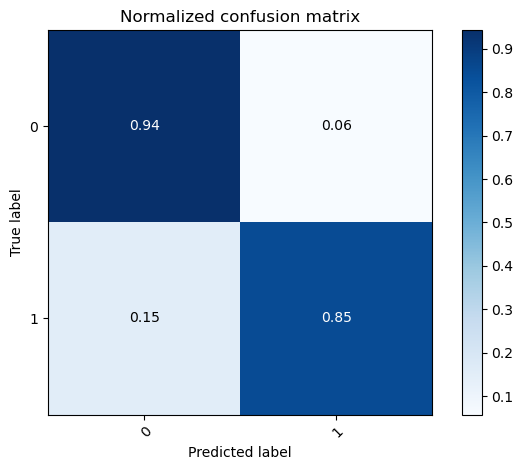

In [118]:
plot_confusion_matrix(y_true, y_pred, normalize=True)

In [117]:
cleanSearch['labels'].value_counts()

0    259
1     97
Name: labels, dtype: int64